# **PREDICTING THE PRIMARY CATEGORY OF WINE**
In this project, the objective is to predict the primary category of wine based on its physicochemical data. 
The primary category of the wine can be either red or white since it will have a bigger contrast contributing
to better model accuracy.

# Importing libraries

In [1]:
import pandas as pd
import numpy as np

# for converting arff to csv
!pip install liac-arff
import arff
import csv

# for one-hot encoding and standardization
from sklearn.preprocessing import LabelEncoder, StandardScaler

# data splitting
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# plots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap

  Preparing metadata (setup.py) ... - done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=18c961f45ef8ce05c3bf4dc7e296743072b43a632ec8a1742cb70c7bfbcfc3b6
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


# Loading Datasets

In [2]:
wine_set_kaggle = pd.read_csv('/kaggle/input/wine-quality-data-set-red-white-wine/wine-quality-white-and-red.csv')
wine_set_kaggle.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Converting the second data set from arff to csv format.

In [3]:
with open('/kaggle/input/wine-set-openml/dataset_.arff', 'r') as arff_file:
    arff_data = arff.load(arff_file) #dictionary containing data and attributes

data = arff_data['data']
attributes = arff_data['attributes']

with open('wine_set_openml.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([attr[0] for attr in attributes])
    writer.writerows(data)
    
wine_set_openml = pd.read_csv('wine_set_openml.csv')
wine_set_openml.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,style
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


# Data preparation

Ensuring that the columns are aligned and named consistently across both datasets.

In [4]:
wine_set_openml.insert(0, 'type', wine_set_openml.pop('style'))

wine_set_openml.columns = wine_set_openml.columns.str.replace('_', ' ')
wine_set_openml.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,red,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,red,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,red,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,red,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Data description to compare the values in both datasets.

In [5]:
wine_set_kaggle.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
wine_set_openml.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
wine_set_kaggle.shape , wine_set_openml.shape

((6497, 13), (6497, 13))

How can both of them have same values???? huh ???? 🤔
They have the same shape and the same statistics.

# Merging the datasets

Checking if they are completely equal.

In [8]:
def are_equal_datasets(df1, df2):
    if df1.shape != df2.shape:
        return False
    df1_sorted = df1.sort_values(by=df1.columns.tolist()).reset_index(drop=True)
    df2_sorted = df2.sort_values(by=df2.columns.tolist()).reset_index(drop=True)
    return df1_sorted.equals(df2_sorted)

are_equal_datasets(wine_set_kaggle, wine_set_openml)

False

Because they have some distinct rows between them, we can merge one of the datasets with the distinct rows.

In [9]:
merged_diff = pd.merge(wine_set_kaggle, wine_set_openml, indicator=True, how='outer')
different_rows = merged_diff[merged_diff['_merge'] != 'both']
different_rows_from_openml = different_rows[wine_set_openml.columns]

merged_set = pd.concat([wine_set_kaggle, different_rows_from_openml], ignore_index=True)

# Checking for null values

In [10]:
merged_set.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

There aren't any null values which is great.

# Deleting unneeded columns

In my opinion quality score from the wine experts is not connected with the color of the wine.


In [11]:
merged_set = merged_set.drop(columns=['quality'])

# Data analysis

Using boxplot.

fixed acidity              Axes(0.125,0.712609;0.168478x0.167391)
volatile acidity        Axes(0.327174,0.712609;0.168478x0.167391)
citric acid             Axes(0.529348,0.712609;0.168478x0.167391)
residual sugar          Axes(0.731522,0.712609;0.168478x0.167391)
chlorides                  Axes(0.125,0.511739;0.168478x0.167391)
free sulfur dioxide     Axes(0.327174,0.511739;0.168478x0.167391)
total sulfur dioxide    Axes(0.529348,0.511739;0.168478x0.167391)
density                 Axes(0.731522,0.511739;0.168478x0.167391)
pH                          Axes(0.125,0.31087;0.168478x0.167391)
sulphates                Axes(0.327174,0.31087;0.168478x0.167391)
alcohol                  Axes(0.529348,0.31087;0.168478x0.167391)
dtype: object

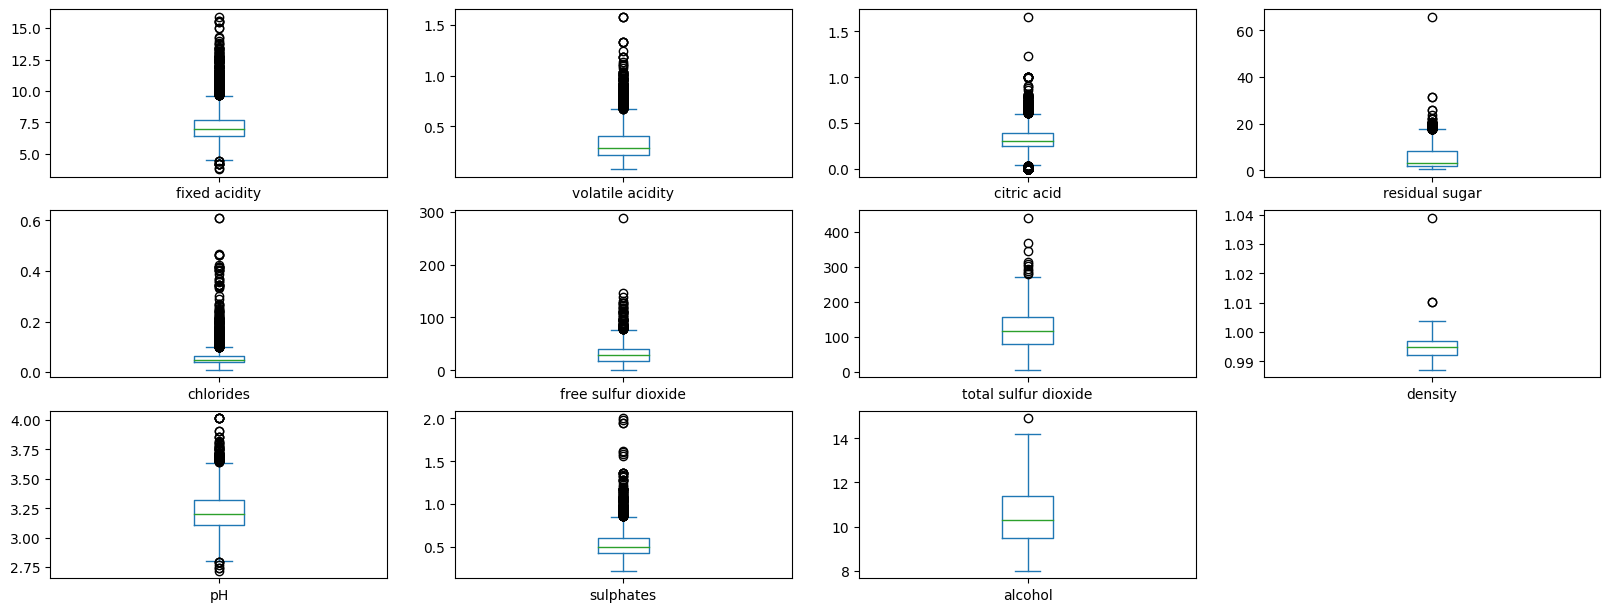

In [12]:
merged_set.plot(kind='box', subplots=True, layout=(4,4), sharex=False, figsize=(20, 10))

Creating histograms to see the distribution of the values.

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>, <Axes: >]], dtype=object)

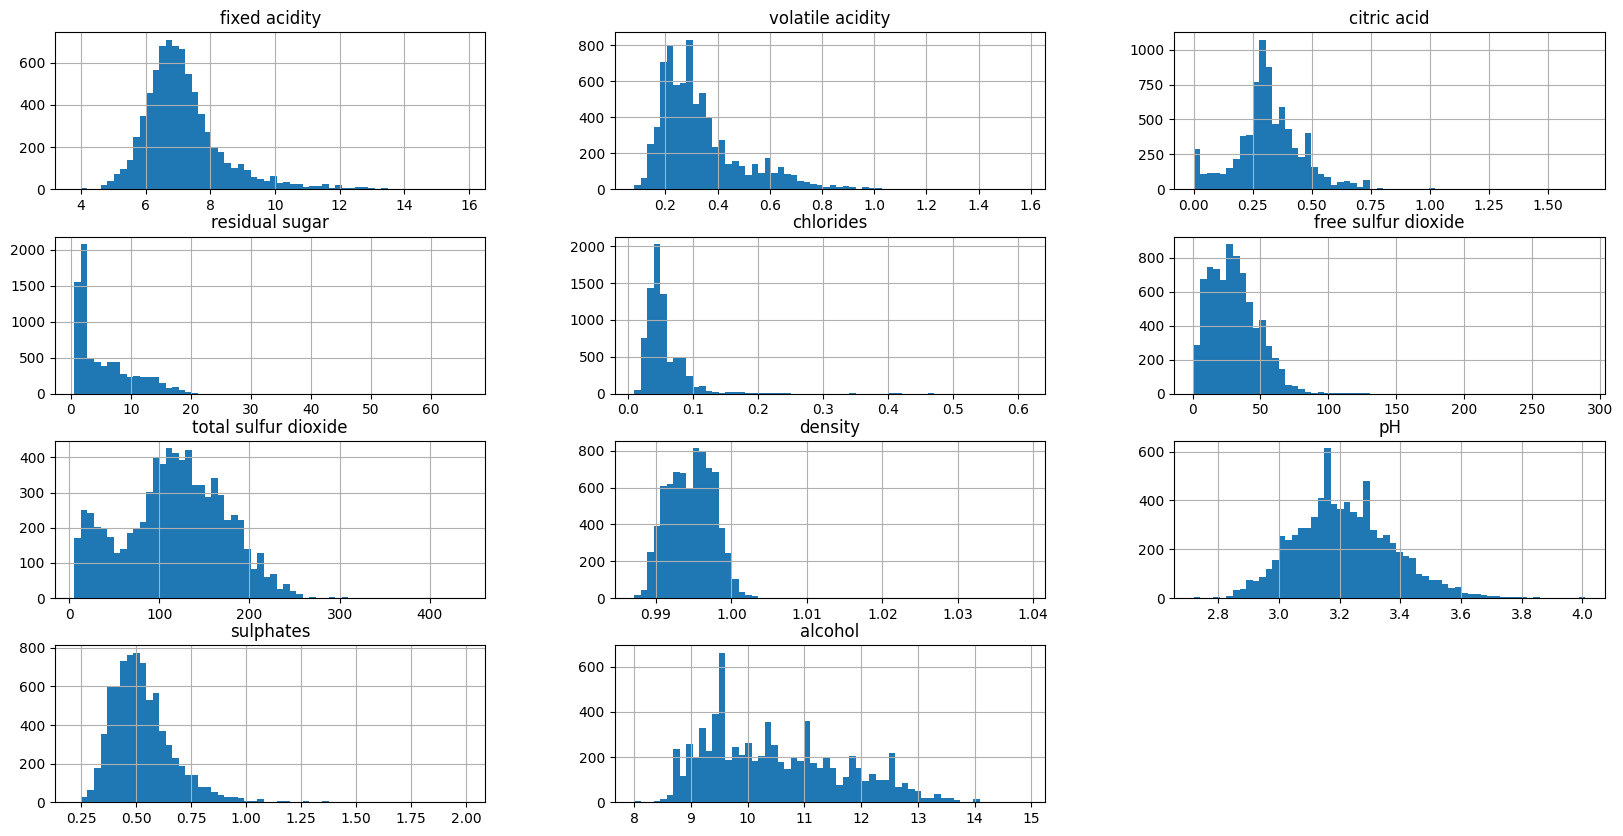

In [13]:
merged_set.hist(bins=60, figsize=(20, 10))

In the histograms we can see that some values go so far on the x axis, that means that there is at least one row with that value (probably outliers).

# Adding IDs to the dataset

In [14]:
merged_set['id'] = merged_set.index

# Dealing with outliers

The residual sugar has a big difference between its minimal and maximal value. According to Goolge, the maximum should be around 19 g/l, but it also says that there are some white wines with even 60 g/l of residual sugar.
I will proceed to check which ones have more than 20 g/l of residual sugar.

In [15]:
merged_set[merged_set['residual sugar']>20]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,id
0,white,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,0
7,white,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,7
182,white,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,182
191,white,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,191
444,white,6.9,0.240,0.36,20.80,0.031,40.0,139.0,0.99750,3.20,0.33,11.0,444
1608,white,6.9,0.270,0.49,23.50,0.057,59.0,235.0,1.00240,2.98,0.47,8.6,1608
1653,white,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,1653
1663,white,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,1663
2620,white,6.5,0.280,0.28,20.40,0.041,40.0,144.0,1.00020,3.14,0.38,8.7,2620
2781,white,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,2781


Scatter plot will nicely show the outlier.

<Axes: xlabel='id', ylabel='residual sugar'>

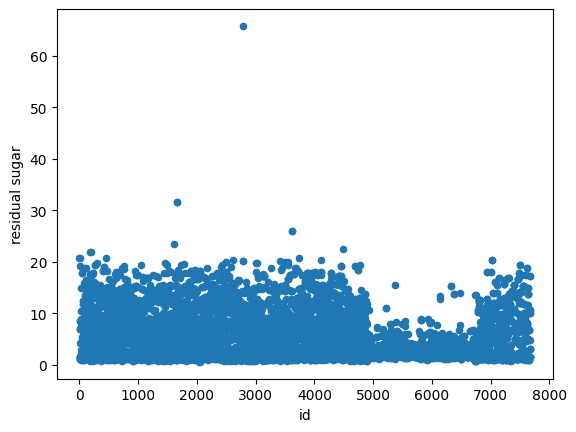

In [16]:
merged_set[['id','residual sugar']].plot(kind='scatter', x='id', y='residual sugar')

I decided to remove the wine with more than 60 g/l residual sugar because its value is double of the biggest before it.


In [17]:
merged_set = merged_set[merged_set['residual sugar']<=35.00]

Proceeding to check for other columns that seem to have outliers.

In [18]:
merged_set[merged_set['free sulfur dioxide']>150]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,id
4745,white,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,4745


<Axes: xlabel='id', ylabel='free sulfur dioxide'>

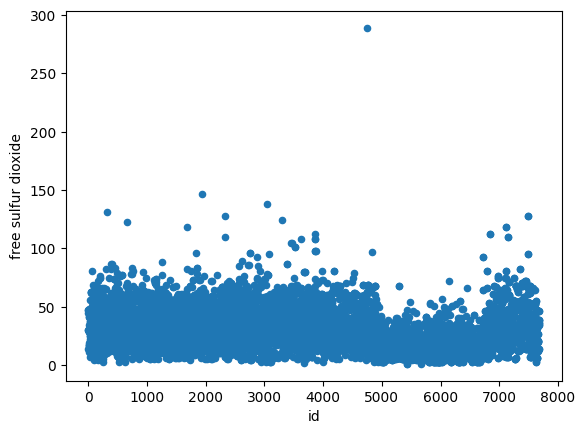

In [19]:
merged_set[['id','free sulfur dioxide']].plot(kind='scatter', x='id', y='free sulfur dioxide') 

I read that to have this much free SO2 in wine is possible in some white wines, but I will delete it anyways.

In [20]:
merged_set = merged_set[merged_set['free sulfur dioxide'] <= 150]

<Axes: xlabel='id', ylabel='citric acid'>

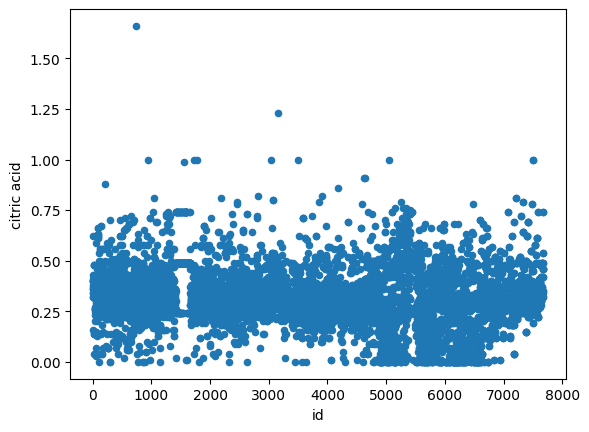

In [21]:
merged_set[['id','citric acid']].plot(kind='scatter', x='id', y='citric acid') 

In [22]:
merged_set = merged_set[merged_set['citric acid'] <= 1.50]

<Axes: xlabel='id', ylabel='total sulfur dioxide'>

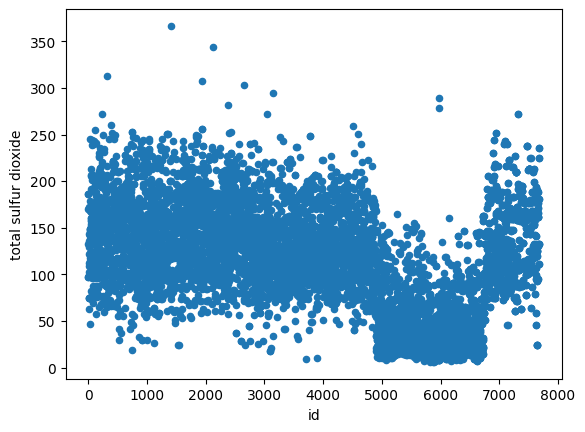

In [23]:
merged_set[['id','total sulfur dioxide']].plot(kind='scatter', x='id', y='total sulfur dioxide') 

In [24]:
merged_set[merged_set['total sulfur dioxide']>350] 

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,id
1417,white,8.6,0.55,0.35,15.55,0.057,35.5,366.5,1.0001,3.04,0.63,11.0,1417


The max legal limit of total SO2 is 350mg/l, but 366.6 is not that far, so I won't delete it.

<Axes: xlabel='id', ylabel='sulphates'>

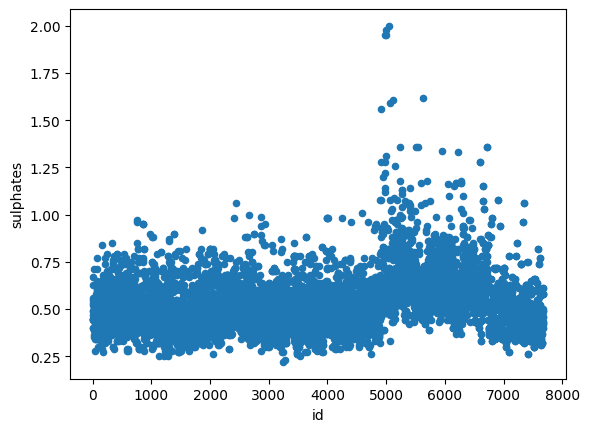

In [25]:
merged_set[['id','sulphates']].plot(kind='scatter', x='id', y='sulphates') 

In [26]:
merged_set[merged_set['sulphates'] >= 1.75]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,id
4984,red,8.6,0.49,0.28,1.9,0.11,20.0,136.0,0.9972,2.93,1.95,9.9,4984
4989,red,8.6,0.49,0.28,1.9,0.11,20.0,136.0,0.9972,2.93,1.95,9.9,4989
4990,red,8.6,0.49,0.29,2.0,0.11,19.0,133.0,0.9972,2.93,1.98,9.8,4990
5049,red,9.2,0.52,1.00,3.4,0.61,32.0,69.0,0.9996,2.74,2.00,9.4,5049


In [27]:
merged_set = merged_set[merged_set['sulphates'] <= 1.75]

fixed acidity              Axes(0.125,0.712609;0.168478x0.167391)
volatile acidity        Axes(0.327174,0.712609;0.168478x0.167391)
citric acid             Axes(0.529348,0.712609;0.168478x0.167391)
residual sugar          Axes(0.731522,0.712609;0.168478x0.167391)
chlorides                  Axes(0.125,0.511739;0.168478x0.167391)
free sulfur dioxide     Axes(0.327174,0.511739;0.168478x0.167391)
total sulfur dioxide    Axes(0.529348,0.511739;0.168478x0.167391)
density                 Axes(0.731522,0.511739;0.168478x0.167391)
pH                          Axes(0.125,0.31087;0.168478x0.167391)
sulphates                Axes(0.327174,0.31087;0.168478x0.167391)
alcohol                  Axes(0.529348,0.31087;0.168478x0.167391)
id                       Axes(0.731522,0.31087;0.168478x0.167391)
dtype: object

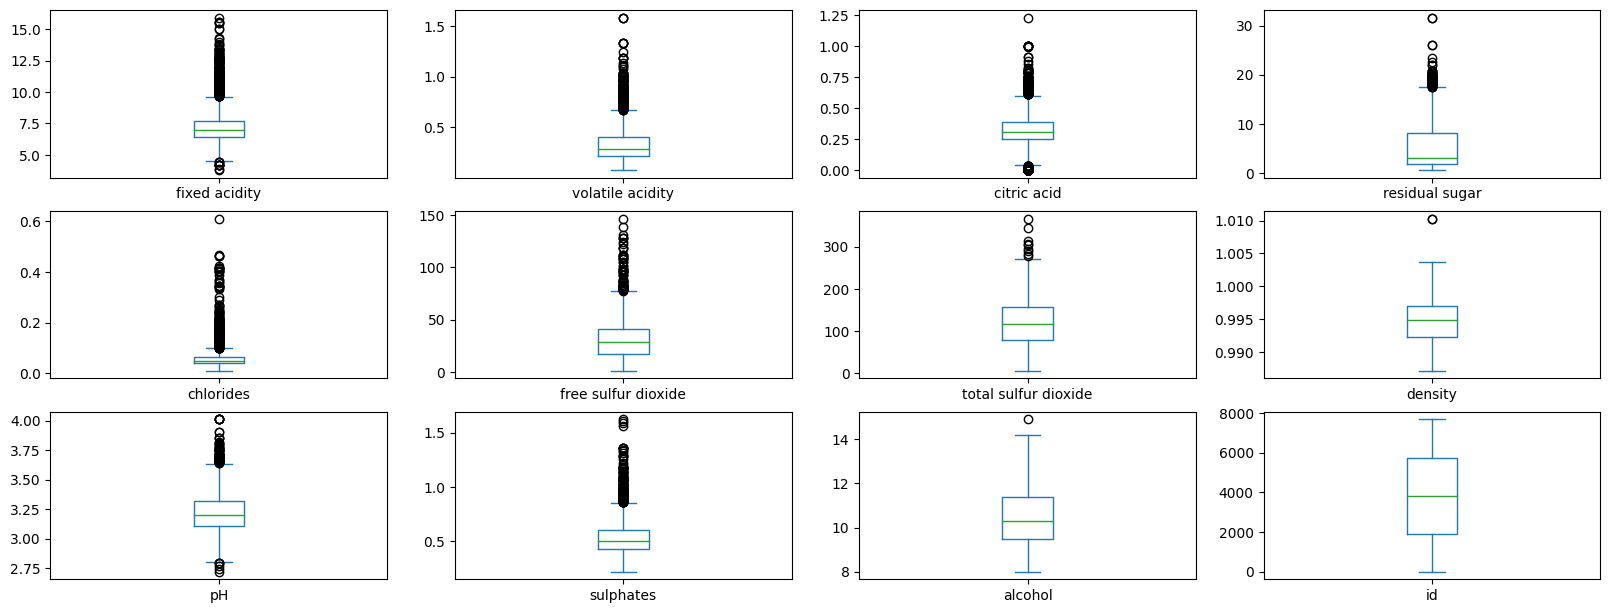

In [28]:
merged_set.plot(kind='box', subplots=True, layout=(4,4), sharex=False, figsize=(20, 10))

In [29]:
merged_set.shape

(7672, 13)

# Balancing the data

In [30]:
merged_set['type'].value_counts()

type
white    5849
red      1823
Name: count, dtype: int64

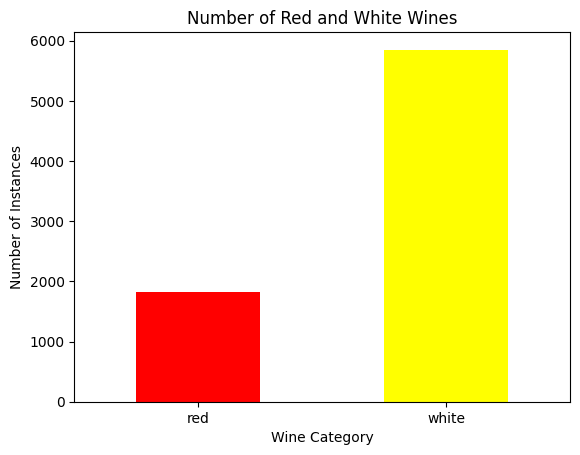

In [31]:
wine_counts = merged_set.groupby('type')['id'].count()

wine_counts.plot(kind='bar', color=['red', 'yellow'])
plt.xlabel('Wine Category')
plt.ylabel('Number of Instances')
plt.title('Number of Red and White Wines')
plt.xticks(rotation=0) 
plt.show()


**Decided to remove some of the white wines to balance the dataset.**

In [32]:
remove_indices = merged_set[merged_set['type'] == 'white'].sample(frac=0.7).index
merged_set = merged_set.drop(remove_indices)

merged_set['type'].value_counts()

type
red      1823
white    1755
Name: count, dtype: int64

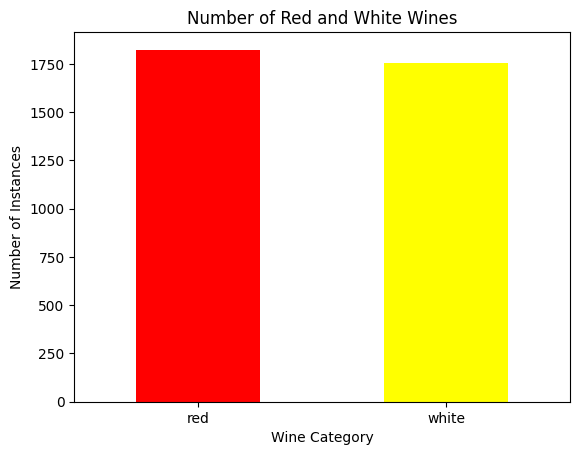

In [33]:
wine_counts = merged_set.groupby('type')['id'].count()

wine_counts.plot(kind='bar', color=['red', 'yellow'])
plt.xlabel('Wine Category')
plt.ylabel('Number of Instances')
plt.title('Number of Red and White Wines')
plt.xticks(rotation=0)  
plt.show()

# Splitting dataset
 And one-hot encoding.

In [34]:
X = merged_set.drop(columns=['type', 'id'])
y = merged_set['type'] 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#just to check if there realy are just 2 values
"Unique values in y:", np.unique(y)

('Unique values in y:', array([0, 1]))

DecisionTreeClassifier(random_state=42)
Accuracy: 0.984 (0.003)


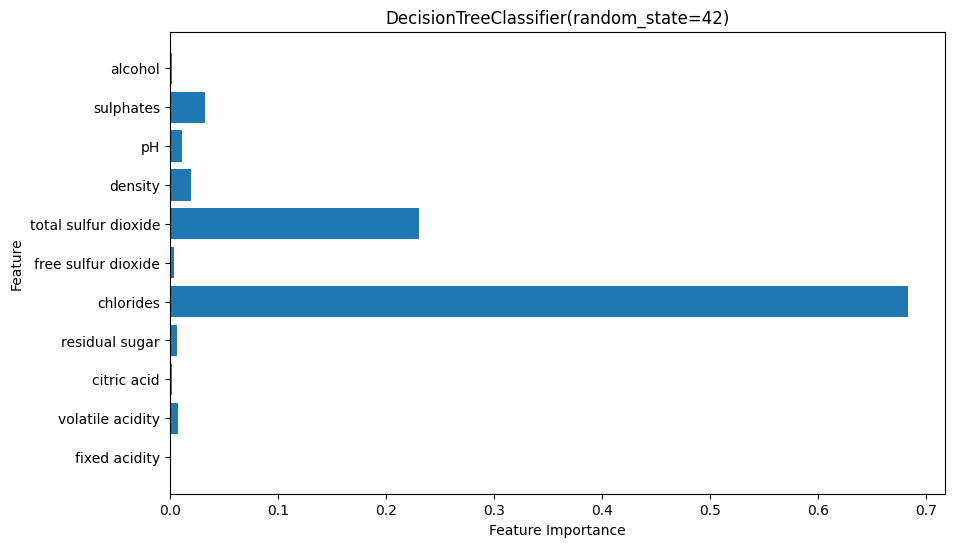

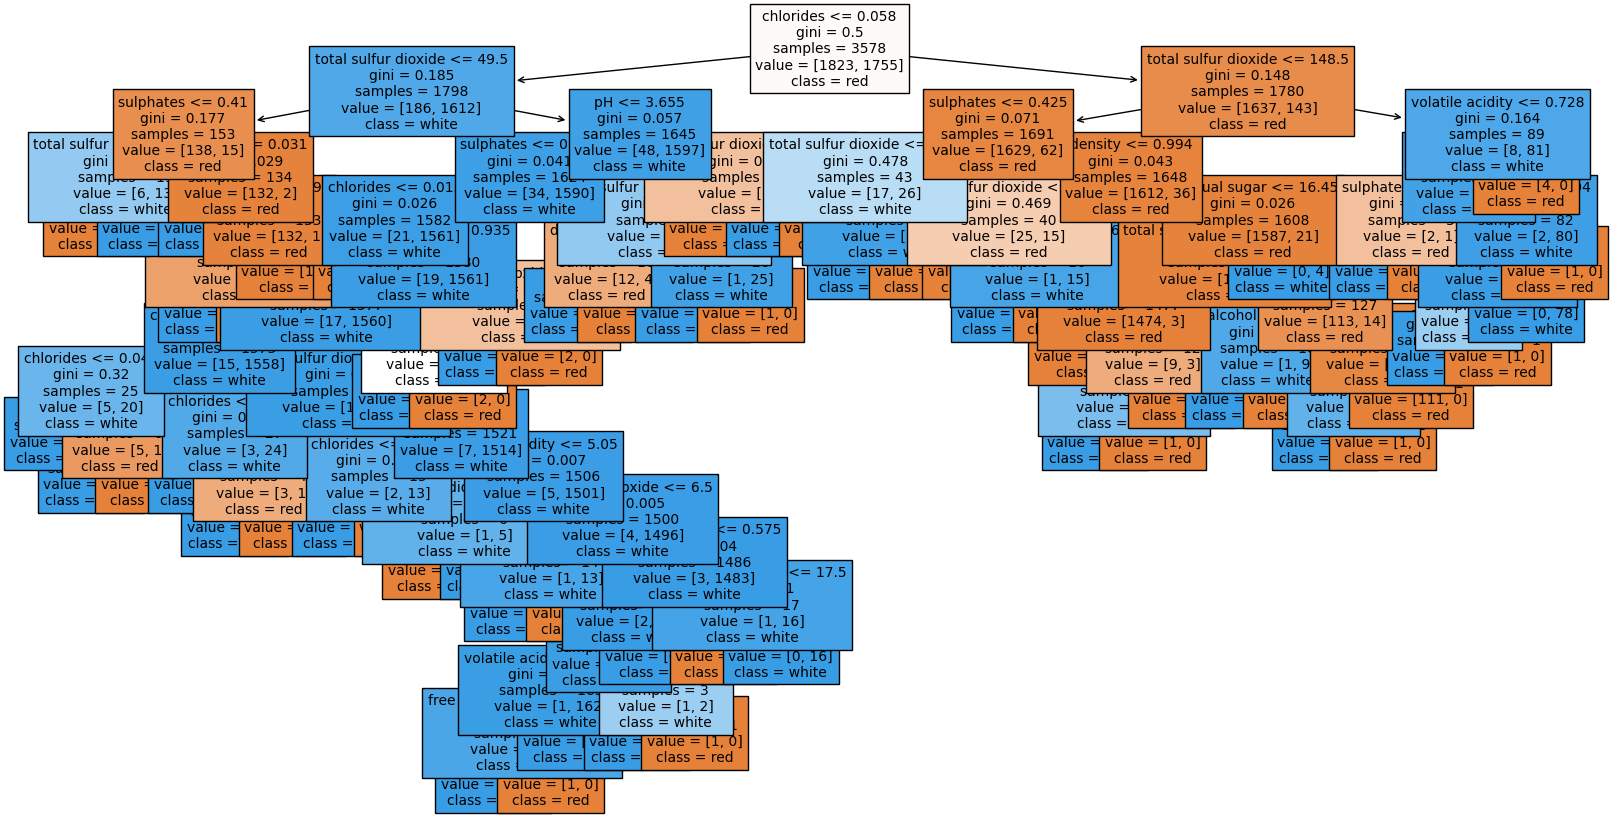

RandomForestClassifier(random_state=42)
Accuracy: 0.995 (0.004)


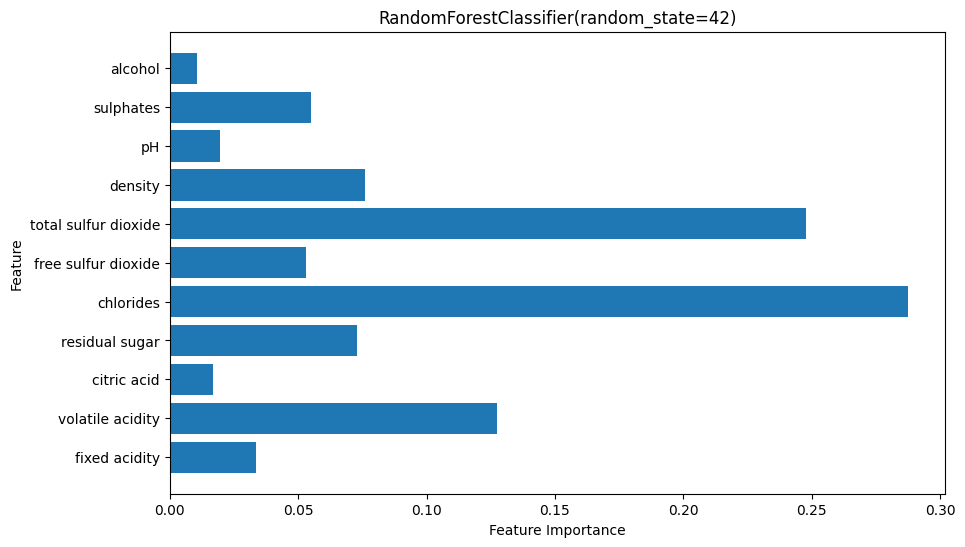

LogisticRegression()


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy: 0.977 (0.008)
HistGradientBoostingClassifier(random_state=42)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.994 (0.005)
KNeighborsClassifier(n_neighbors=3)
Accuracy: 0.924 (0.012)


In [35]:
# X = merged_set.drop(columns=['type', 'id'])
# y = merged_set['type'] 
cv = KFold(n_splits=10, random_state=1, shuffle=True)

models = [ DecisionTreeClassifier(random_state=42), 
           RandomForestClassifier(n_estimators=100, random_state=42),
           LogisticRegression(),
           HistGradientBoostingClassifier(random_state=42),
           KNeighborsClassifier(n_neighbors=3)]

for model in models:
    print(model)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    model.fit(X, y)
    if (isinstance(model,RandomForestClassifier) or isinstance(model,DecisionTreeClassifier)):
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(model.feature_importances_)), model.feature_importances_)
        plt.yticks(range(len(X.columns)), X.columns)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(model)
        plt.show()
    
    if isinstance(model,DecisionTreeClassifier):
        plt.figure(figsize=(20, 10))
        plot_tree(model, filled=True, feature_names=X.columns, class_names=['red', 'white'], fontsize=10)
        plt.show()

# Decision tree classifier

Accuracy: 0.9930167597765364


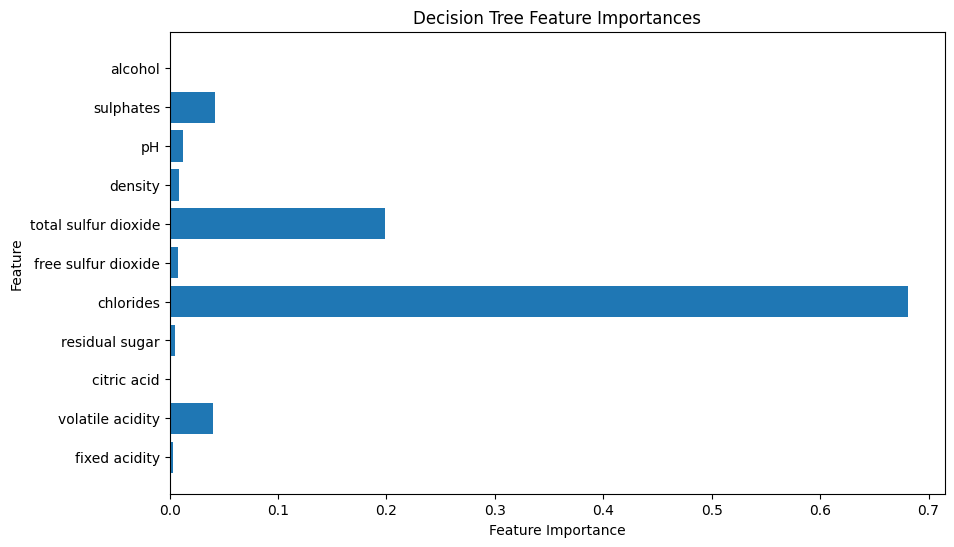

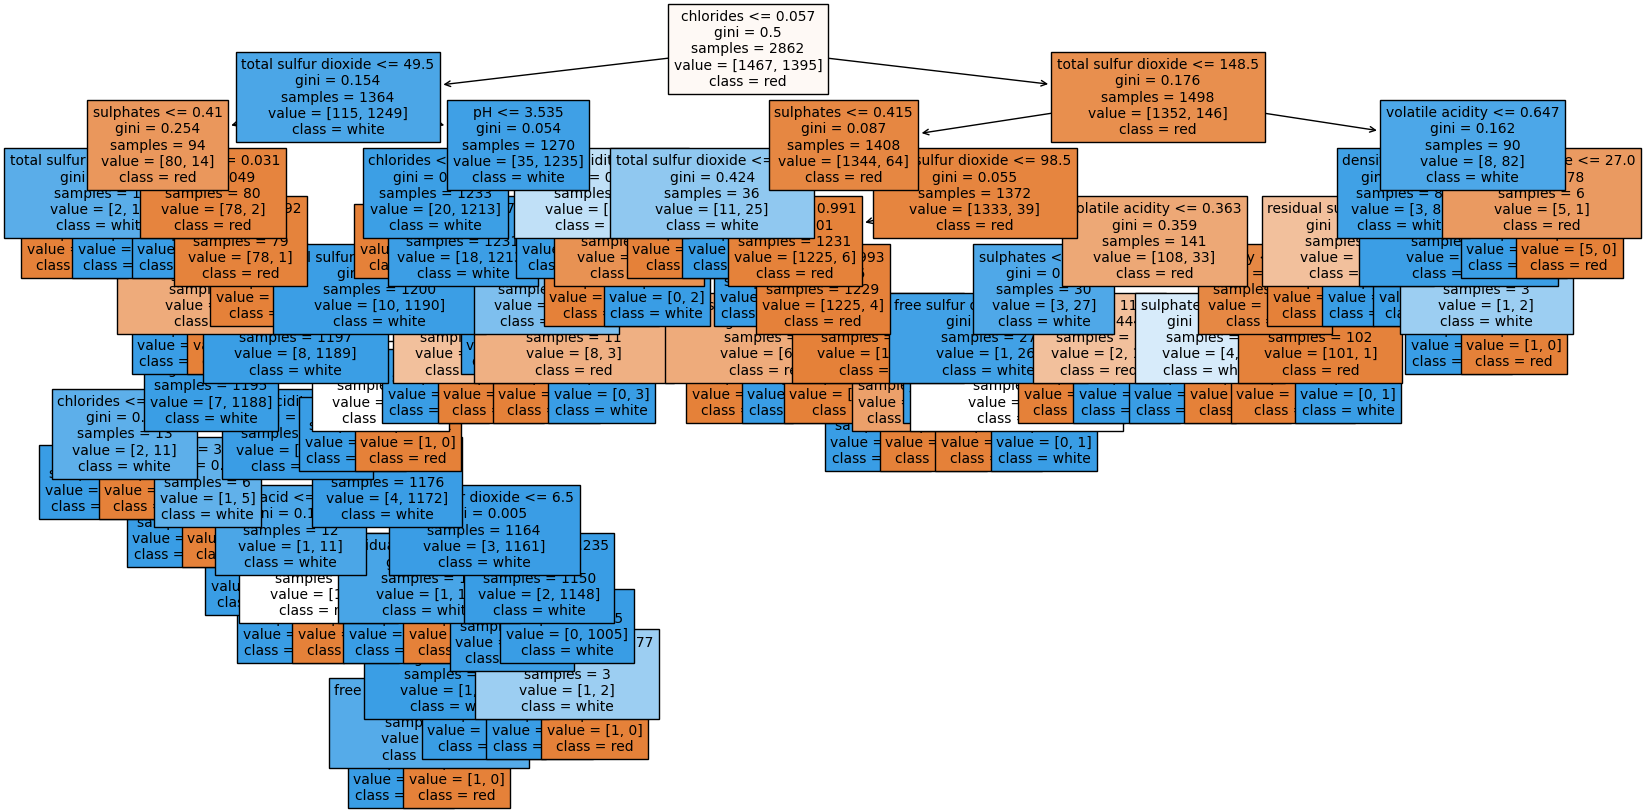

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       356
           1       0.99      1.00      0.99       360

    accuracy                           0.99       716
   macro avg       0.99      0.99      0.99       716
weighted avg       0.99      0.99      0.99       716

[[352   4]
 [  1 359]]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# feature importances plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(dt_classifier.feature_importances_)), dt_classifier.feature_importances_)
plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Decision Tree Feature Importances")
plt.show()

# the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=['red', 'white'], fontsize=10)
plt.show()

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

# Random Forest Classifier

Random Forest Accuracy: 0.9972067039106145


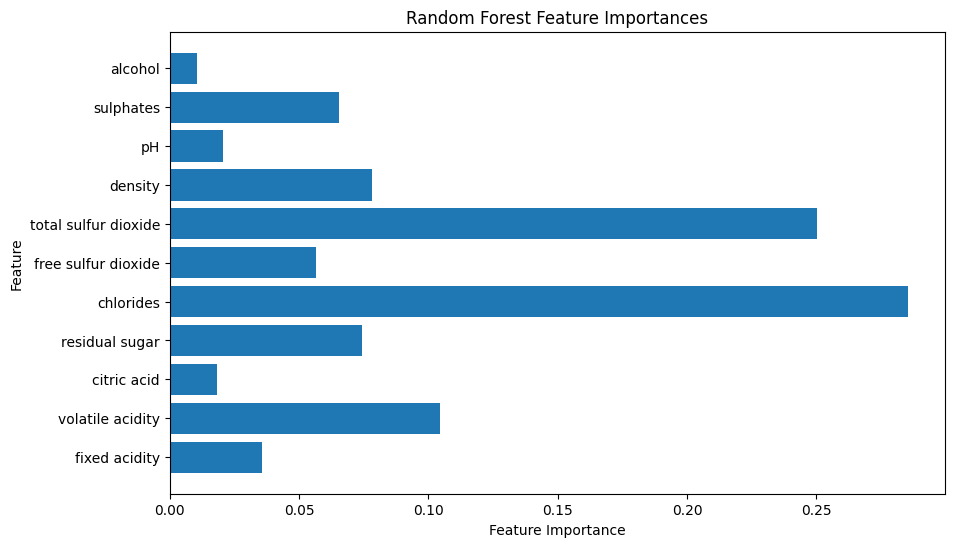

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       356
           1       0.99      1.00      0.99       360

    accuracy                           0.99       716
   macro avg       0.99      0.99      0.99       716
weighted avg       0.99      0.99      0.99       716

[[352   4]
 [  1 359]]


In [37]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

# feature importances plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_classifier.feature_importances_)), rf_classifier.feature_importances_)
plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

# Logistic Regression

In [38]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

y_pred_lr = lr_classifier.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)

Logistic Regression Accuracy: 0.979050279329609


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# HistGradientBoostingClassifier

In [39]:
hgb_classifier = HistGradientBoostingClassifier(random_state=42)
hgb_classifier.fit(X_train, y_train)

y_pred = hgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

false_positives = X_test[(y_test == 'red') & (y_pred == 'white')]
print(false_positives) #the false positives doesn't seem odd

Accuracy: 0.9986033519553073
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       356
           1       1.00      1.00      1.00       360

    accuracy                           1.00       716
   macro avg       1.00      1.00      1.00       716
weighted avg       1.00      1.00      1.00       716

[[356   0]
 [  1 359]]
Empty DataFrame
Columns: [fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol]
Index: []


In [40]:
merged_set.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,id
count,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000,3578.000000
mean,7.601020,0.407332,0.301579,4.451453,0.067004,25.445640,91.451090,0.995384,3.248566,0.570662,10.485630,4576.384013
std,1.524442,0.196525,0.164454,4.120346,0.042742,17.034907,59.257218,0.002823,0.167543,0.160688,1.184527,2024.292738
min,4.200000,0.080000,0.000000,0.700000,0.012000,1.000000,6.000000,0.987110,2.720000,0.250000,8.000000,3.000000
25%,6.600000,0.260000,0.210000,1.900000,0.042000,12.000000,37.000000,0.993400,3.140000,0.460000,9.500000,3103.250000
50%,7.200000,0.360000,0.300000,2.400000,0.058000,22.000000,89.000000,0.995800,3.240000,0.550000,10.300000,5236.500000
75%,8.200000,0.540000,0.400000,5.800000,0.082000,35.000000,136.000000,0.997400,3.360000,0.650000,11.300000,6130.750000
max,15.900000,1.580000,1.230000,26.050000,0.611000,146.500000,307.500000,1.003690,4.010000,1.620000,14.900000,7677.000000


# K-Means and K-Nearest Neighbor

Most of the code for KNN algorithm is used from [Plot k-Nearest-Neighbor graph with 8 features?](https://stackoverflow.com/questions/56153726/plot-k-nearest-neighbor-graph-with-8-features).

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.9986033519553073


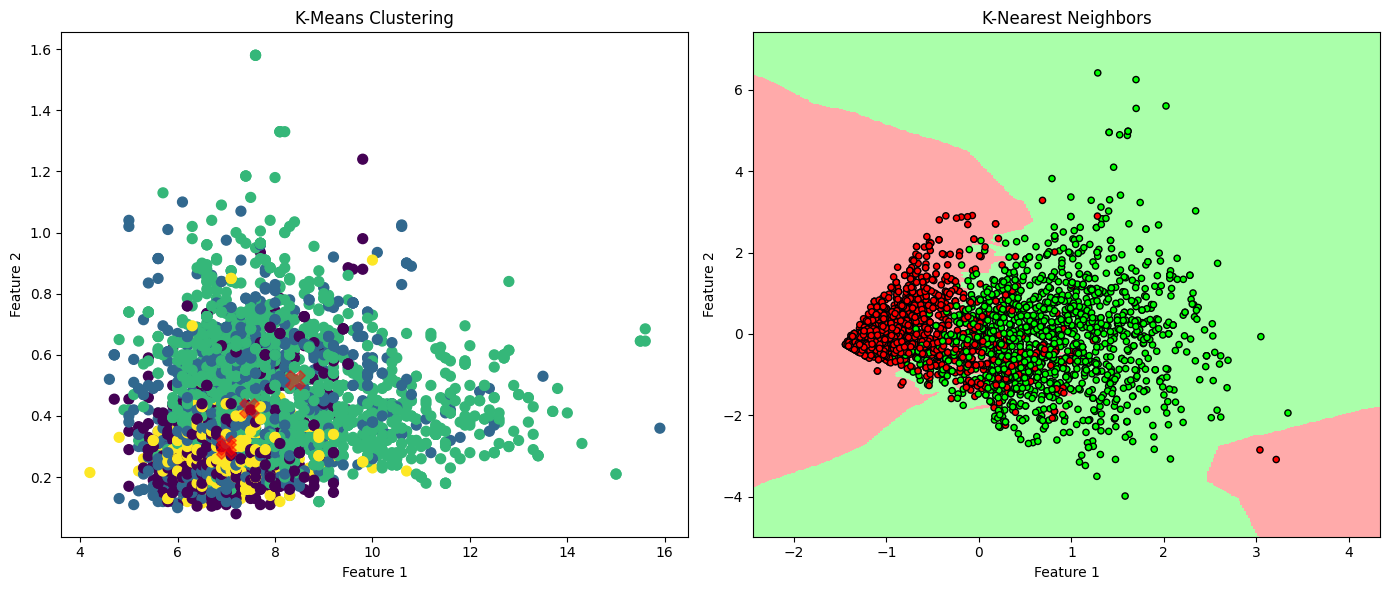

In [41]:
X = merged_set.drop(['type', 'id'], axis=1).values  
y = merged_set['type']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.figure(figsize=(14, 6))

# k-means plot
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering')

# knn plot
plt.subplot(1, 2, 2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("K-Nearest Neighbors")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

plt.tight_layout()
plt.show()